In [1]:
# 导入环境的包
import time
import sys
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph
import seaborn as sns  # used for plot interactive graph.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

from tcn import TCN
from tensorflow.keras.layers import Dense,Dropout,LSTM,GRU
from tensorflow.keras import Input, Model,Sequential

In [2]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 30, 10
register_matplotlib_converters()

In [3]:
#将序列转为监督学习序列数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
daily_cases_ = pd.read_csv('../new_daily_cases/new_daily_cases_China.csv').iloc[:,1:]
df_resample=daily_cases_.T
df_resample

,0
1/23/20,0.0
1/24/20,0.0
1/25/20,0.0
1/26/20,0.0
1/27/20,0.0
...,...
5/10/22,7895.0
5/11/22,7357.0
5/12/22,7118.0
5/13/22,6768.0


In [5]:
## * Note: 归一化数据范围为0-1.

values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 数据转为监督学习数据，time-step=1
reframed = series_to_supervised(scaled, 1, 1)

In [6]:
# 划分数据集
values = reframed.values
#https://easy-station.taobao.com/
#一般训练数据集以总数据的*0.7，测试数据以总数据的*0.3，
train = values[400:-7, :]
test = values[-7:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 构建数据的3D 格式，即[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(435, 1, 1) (435,) (7, 1, 1) (7,)


# 构建TCN-LSTM模型

### 1) TCN 卷积核个数32
### 2) LSTM隐藏层100
### 3) dropout 层20%
### 4) 1个神经元在输出层中。
### 5) 输入形状为1个时间步长，有1个特征

### 6)使用了平均绝对误差（MAE）损失函数和随机梯度下降的有效Adam。
### 7)  epochs=100, batch size = 8.

In [7]:
time_start = time.time()  # 记录开始时间

#网络结构
model = Sequential()
model.add(TCN(nb_filters=32,kernel_size=3,padding='causal',return_sequences=True,dilations=(1, 2, 4, 8,16), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("train time:",time_sum)

# 显示训练的loss值情况
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss in TCN-LSTM')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

time_start = time.time()  # 记录开始时间

# 做预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# i反归一化预测值
inv_yhat = np.concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反归一化真实值
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("predict time:",time_sum)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

Epoch 1/100
44/44 - 4s - loss: 0.0129 - val_loss: 0.0026
Epoch 2/100
44/44 - 0s - loss: 0.0148 - val_loss: 0.0031
Epoch 3/100
44/44 - 0s - loss: 0.0187 - val_loss: 0.0160
Epoch 4/100
44/44 - 0s - loss: 0.0061 - val_loss: 0.0011
Epoch 5/100
44/44 - 0s - loss: 0.0088 - val_loss: 5.7543e-05
Epoch 6/100
44/44 - 0s - loss: 0.0108 - val_loss: 0.0066
Epoch 7/100
44/44 - 0s - loss: 0.0041 - val_loss: 1.5910e-05
Epoch 8/100
44/44 - 0s - loss: 0.0042 - val_loss: 0.0016
Epoch 9/100
44/44 - 0s - loss: 0.0045 - val_loss: 3.2768e-04
Epoch 10/100
44/44 - 0s - loss: 0.0046 - val_loss: 0.0024
Epoch 11/100
44/44 - 0s - loss: 0.0044 - val_loss: 3.7709e-04
Epoch 12/100
44/44 - 0s - loss: 0.0035 - val_loss: 0.0037
Epoch 13/100
44/44 - 0s - loss: 0.0031 - val_loss: 0.0024
Epoch 14/100
44/44 - 0s - loss: 0.0028 - val_loss: 0.0040
Epoch 15/100
44/44 - 0s - loss: 0.0027 - val_loss: 0.0030
Epoch 16/100
44/44 - 0s - loss: 0.0031 - val_loss: 0.0039
Epoch 17/100
44/44 - 0s - loss: 0.0031 - val_loss: 0.0026
Epoch 1

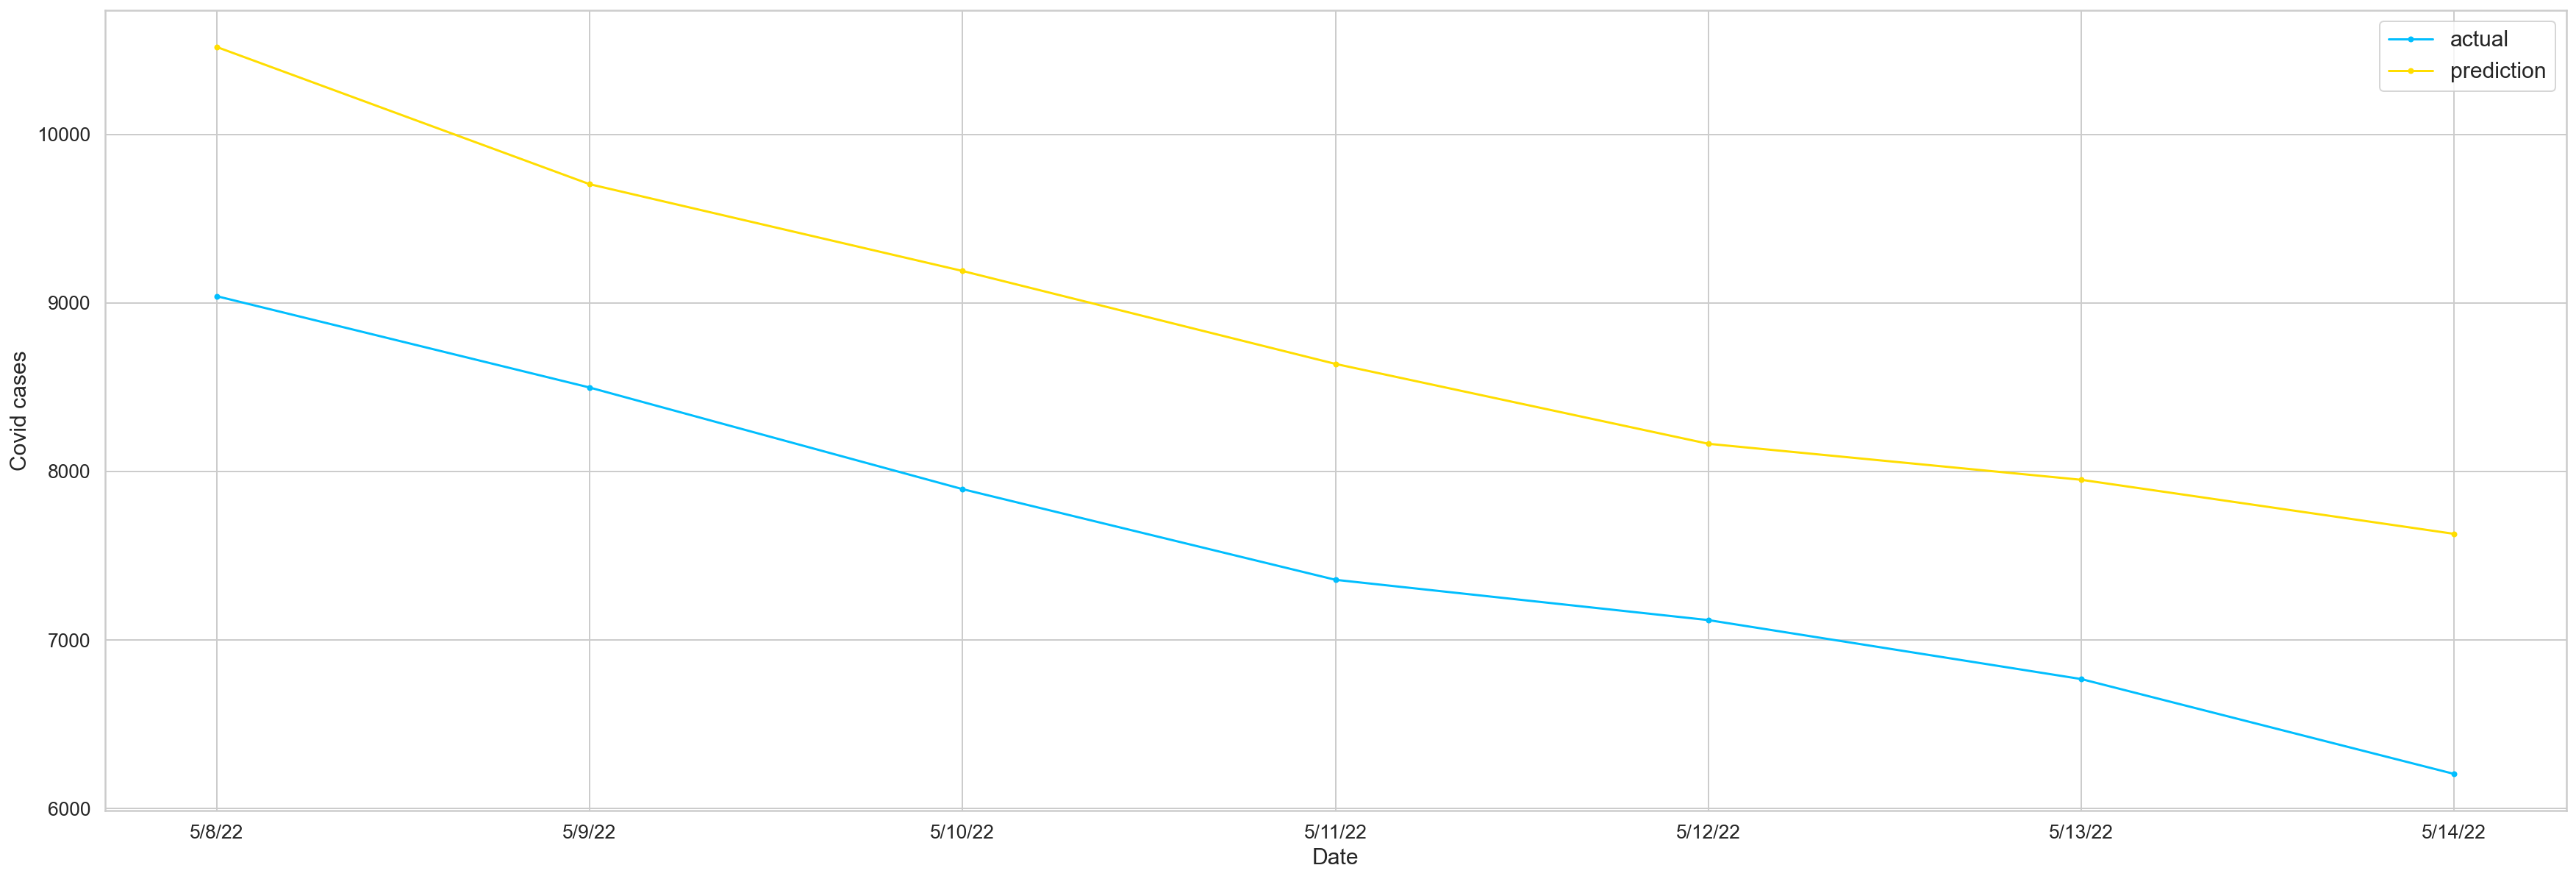

In [8]:
# 显示预测结果
plt.plot(df_resample.index[-7:], inv_y[-7:], marker='.', label="actual")
plt.plot(df_resample.index[-7:], inv_yhat[:],  marker='.',label="prediction")
plt.ylabel('Covid cases', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()

In [9]:
true_cases=inv_y
predicted_cases=inv_yhat
predicted_cases.astype(int)

array([10518,  9704,  9189,  8638,  8164,  7950,  7629])

In [10]:

# MSE = np.linalg.norm(true_cases-predicted_cases, ord=2)**2/len(true_cases)

RMSE = np.linalg.norm(true_cases-predicted_cases, ord=2)/len(true_cases)**0.5

NRMSE=RMSE/(np.max(true_cases)-np.min(true_cases))

# MAE = np.linalg.norm(true_cases-predicted_cases, ord=1)/len(true_cases)

MAPE=100 * np.mean(np.abs(true_cases-predicted_cases)) / np.mean(true_cases) 

SMAPE=200 * np.mean(np.abs(true_cases-predicted_cases) / (np.abs(true_cases) + np.abs(predicted_cases))) 


RMSE = round(RMSE,4)

NRMSE = round(NRMSE,4)

MAPE = round(MAPE,4)

SMAPE = round(SMAPE,4)

summary=[RMSE,NRMSE,MAPE,SMAPE]

summary

[1280.6461, 0.4517, 16.856, 15.6998]

In [11]:
history.history['loss']

[0.012902560643851757,
 0.01484204176813364,
 0.018650075420737267,
 0.006079631391912699,
 0.008784757927060127,
 0.010826549492776394,
 0.004081278573721647,
 0.004163940902799368,
 0.004454769194126129,
 0.0045687733218073845,
 0.004353666678071022,
 0.0034868691582232714,
 0.003099978668615222,
 0.0028458465822041035,
 0.002679901896044612,
 0.003111176658421755,
 0.003057418391108513,
 0.003012014552950859,
 0.004590644966810942,
 0.003761113388463855,
 0.004328940063714981,
 0.003761045401915908,
 0.0044027771800756454,
 0.0028063557110726833,
 0.0028047936502844095,
 0.002419134369120002,
 0.0027444716542959213,
 0.002691479865461588,
 0.002728221006691456,
 0.0022686116863042116,
 0.0024803820997476578,
 0.002566057723015547,
 0.0025203030090779066,
 0.0024330650921911,
 0.003304176963865757,
 0.0031286166049540043,
 0.0044174944050610065,
 0.003022274235263467,
 0.0027585430070757866,
 0.0027217899914830923,
 0.004570838063955307,
 0.0036110347136855125,
 0.004604832269251347,

In [12]:
history.history['val_loss']

[0.0025906278751790524,
 0.003063146024942398,
 0.016031157225370407,
 0.0011424422264099121,
 5.75429767195601e-05,
 0.006627161521464586,
 1.5910218280623667e-05,
 0.0016391046810895205,
 0.0003276752249803394,
 0.002358746249228716,
 0.00037708907620981336,
 0.0036787446588277817,
 0.002378215780481696,
 0.004045343492180109,
 0.0030465254094451666,
 0.003887397004291415,
 0.002589563140645623,
 0.005283046048134565,
 0.0008008666918613017,
 0.006859191693365574,
 0.0006088592926971614,
 0.003759377868846059,
 1.5064811123011168e-05,
 0.006146431900560856,
 0.002992141293361783,
 0.004063186701387167,
 0.004486192017793655,
 0.0033365595154464245,
 0.0028931533452123404,
 0.004426499828696251,
 0.004482816439121962,
 0.004583974834531546,
 0.003244256367906928,
 0.0033386466093361378,
 0.00088690739357844,
 0.0019073208095505834,
 0.00010447554814163595,
 0.002919865772128105,
 0.0013383583864197135,
 0.0028177795466035604,
 2.3574737497256137e-05,
 0.005374315660446882,
 1.89090387